# Damage Assessment from image during natural disasters

Initial notebook to reproduce the results of the paper and try other models that could provide better performance.We wrote and experiment script and manually  try several experiments with VGG16 and EfficientNet.The final experiment module will be automated and reproducable in another script. 

For the AWS disaster response hackathon one of the challenge is to answer the question : **HOW MIGHT WE ACCURATELY AND EFFICIENTLY DETERMINE THE EXTENT OF DAMAGE TO INDIVIDUAL HOMES IN A GIVEN DISASTER-IMPACTED AREA ?**

To answer that question our team proposed to build and deploy an edge-based computer vision solution on smartphones for damage assessment.

In [1]:
#!pip install pandas
#!pip install tensorflow
!pip install tensorflow_addons
#!pip install matplotlib


In [2]:
import os
import re
import pandas as pd
import numpy as np
import gc

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks,models,layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [3]:
print(tf.__version__)

2.6.0


## Download the data

Images collected from Twitter during four natural disasters, namely Typhoon Ruby (2014), Nepal Earthquake (2015), Ecuador Earthquake (2016), and Hurricane Matthew (2016). In addition to Twitter images, it contains images collected from Google using queries such as "damage building", "damage bridge", and "damage road" to deal with labeled data scarcity problem. The images are labeled in 3 classes:
* Severe
* Mild
* None

In [5]:
# !wget https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz

In [6]:
#!tar -xvzf ASONAM17_Damage_Image_Dataset.tar.gz

## Get data and convert image path and label to csv

In [4]:
import os
cwd = os.getcwd()
cwd

'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\notebooks'

In [8]:
cwd = 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml'

In [9]:
import csv
os.makedirs(f"{cwd}/data/damage_csv",exist_ok=True)
images_path = os.path.join(cwd,'data','ASONAM17_Damage_Image_Dataset')
damage_path = os.path.join(cwd,'data',"damage_csv")

print(images_path)
print(damage_path)

def _get_train_files_by_event(images_path,event_file):
    files =[]
    for f in os.listdir(images_path):
        if not f.startswith('.'):
            if f.startswith(event_file) and os.path.isfile(os.path.join(images_path,f)):
                path = os.path.join(images_path,f)
                files.append(path)
    return files


def _get_train_file_data(file_path):
    data_raw_file = []
    with open(file_path,mode='r',encoding='utf-8') as f:
        for line in f.readlines():
            csvline = []
            image,label = line.split()
            csvline.append(image)
            csvline.append(int(label))
            data_raw_file.append(csvline)
    
    return data_raw_file



def _save_train_file_as_csv(event_file,data_raw_file,damage_path,file_path):
    os.makedirs(f"{damage_path}/{event_file}/",exist_ok=True)
    if file_path.endswith('.dev'):
        file_csv = 'dev.csv'
    elif file_path.endswith('.train'):
        file_csv = 'train.csv'
    elif file_path.endswith('.test'):
        file_csv = 'test.csv'
        
    with open(f"{damage_path}/{event_file}/{file_csv}",mode='w',encoding='utf-8') as f:
        writer = csv.writer(f)
        for row in data_raw_file:
            writer.writerow(row)
        f.close()
        
## Save as CSV all data for an event

def save_all_files(images_path,event_file):
    files = _get_train_files_by_event(images_path,event_file)
    print(files)
    for f in files:
        data_file = _get_train_file_data(f)
        _save_train_file_as_csv(event_file,data_file,damage_path,f) 

        

c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\ASONAM17_Damage_Image_Dataset
c:\Users\wsn8\Code\disaster-damage-assessment-ml\data\damage_csv


In [10]:
save_all_files(images_path,'ecuador')

['c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.dev', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.test', 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset\\ecuador.train']


## Load data in a Tensorflow Dataset

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


IMG_SIZE = 224
batch_size = 32
num_classes = 3

data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

def get_sample():
    pass
    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100):


    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']
    train_df = train_df.sample(frac = 0.1)

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']
    valid_df = valid_df.sample(frac=0.1)

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']
    test_df = test_df.sample(frac=0.1)

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,           
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    print(f"steps_per_epochs: { round(len(train_df)/batch_size)}")
    print(f"validations_steps: { round(len(valid_df)/ batch_size)}")
        
        
    steps_per_epoch = round(len(train_df)/ batch_size)
    validation_steps = round(len(valid_df)/ batch_size)


    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps
    
            



    

In [12]:

train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'cross_event_ecuador',
                                    is_augment=False,batch_size=128,buffer_size=100)
    

Found 2211 validated image filenames.
Found 114 validated image filenames.
Found 114 validated image filenames.
steps_per_epochs: 17
validations_steps: 1


In [13]:
class_names=['none','mild','severe']

## Visualize data

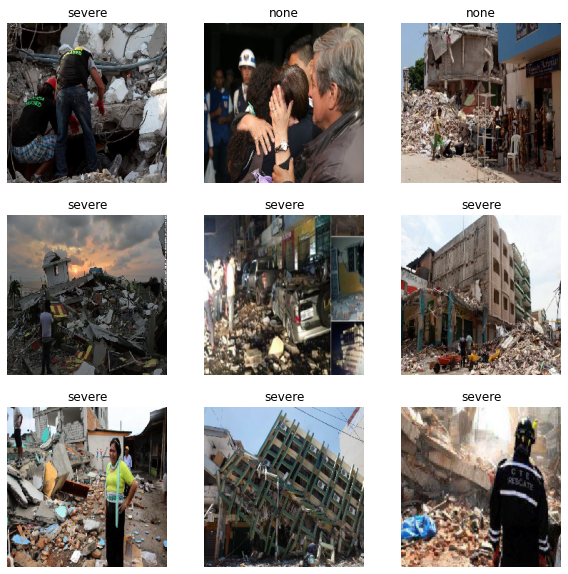

In [14]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

In [15]:
def subplot_learning_curve(model_name,history):
    #plt.clf()
    plt.figure(figsize=(10,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(model_name + ": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

## Create EfficientNet Architecture

In [16]:
from keras.applications.efficientnet import EfficientNetB0

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB0(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

get_efficient_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
___________________________

## Create Experiment

In [17]:
def finetune_model(lr,model_name,train_batches,valid_batches,initial_epoch,
                   epochs, steps_per_epoch,validation_steps,use_clr=False,init_lr=1e-3,max_lr=1e-2,model=None):
    print(f"finetuning lr ={lr}")
    print(f"finetuning epochs ={epochs}")
    print(f"init LR epochs ={init_lr}")
    print(f"max LR epochs ={max_lr}")
    
    if use_clr:
        print("using cyclical LR for finetuning")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr      

    
    if model:
        for layer in model.layers:
            layer.trainable = True
        
        check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
        early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

        model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['acc'])

        print()
        print("Training..................")
        history = model.fit(train_batches,
                        initial_epoch=initial_epoch,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_batches,
                        validation_steps = validation_steps,
                        callbacks=[check,early_stop])
        
        print()
        print('loading best weights model')
        model = models.load_model(f'./model/{model_name}.h5')
       
    return history, model

      
    
    

In [18]:

def run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=32,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=20,init_lr=1e-3,max_lr=1e-2):
    
    print(f"******************{exp_name}*********************************")
    print(f"model_name ={model_name}")
    print(f"data augmentation ={is_augment}")
    print(f"event ={event}")
    print(f"finetuning ={do_finetune}")
    print(f"lr ={lr}")
    print()
    
    gc.collect()

    print(f"Creating dataset.....")
    train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps = create_dataset(damage_path,
                                                                                               event,
                                                                                  is_augment=is_augment,
                                                                                  batch_size= batch_size)
    
    if use_clr:
        print("using cyclical LR for training")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr
   

    print("Model architecture...........")
    if model_name == 'vgg16':
        model = get_vgg16_model(lr=lr)
    if model_name == 'vgg16_fc2':
        model = get_vgg16_fc2_model(lr=lr)
    elif model_name =='efficientnet':
        model = get_efficient_model(lr=lr) 
    elif model_name =='mobilenet':
        model = get_mobilenet_model(lr=lr)

    check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
    early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

    print()
    print("Training..................")
    history = model.fit(train_batches,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_batches,
                validation_steps = validation_steps,
                callbacks=[check,early_stop])
    
    
    print()
    subplot_learning_curve(model_name,history)
    
    print()
    print('loading best weights model')
    #model = models.load_model(f'./model/{model_name}.h5')

    print()
    print(f"Run evaluation.........")   
  
    results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
    results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)

    print()
    print(f"Training accuracy: {results_train['acc']}")
    print(f"Validation accuracy: {results_test['acc']}")
    
    if do_finetune:
        
        if not use_clr:
            #LR finetuning when not using CLR
            lr = lr * 1e-2
        print()
        print(f"******Fine tuning***********************")
        history, model = finetune_model(lr=lr,model_name=model_name,train_batches=train_batches,
                                        valid_batches=valid_batches, initial_epoch=n_epochs,epochs=2*n_epochs,
                                        steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,
                                        use_clr=use_clr,init_lr=init_lr * 1e-2,max_lr=max_lr * 1e-2,model=model)
        print()
        subplot_learning_curve(model_name+"_fintuned",history)
        
        results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
        results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)
        
        print()
        print(f"Training finetune accuracy: {results_train['acc']}")
        print(f"Validation finetune accuracy: {results_test['acc']}")
        

    return results_train['acc'],results_test['acc'],model

## Running Training experiments

In [19]:
### EfficientNet no augmentation

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =cross_event_ecuador
finetuning =False
lr =0.005

Creating dataset.....
Found 2211 validated image filenames.
Found 114 validated image filenames.
Found 114 validated image filenames.
steps_per_epochs: 17
validations_steps: 1
Model architecture...........
lr in model = 0.005
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)    

C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


17/17 [==============================] - 100s 5s/step - loss: 0.7661 - acc: 0.6820 - val_loss: 0.4558 - val_acc: 0.8333


C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/4
17/17 [==============================] - 87s 5s/step - loss: 0.5524 - acc: 0.7931 - val_loss: 0.4437 - val_acc: 0.8509
Epoch 3/4
17/17 [==============================] - 87s 5s/step - loss: 0.4785 - acc: 0.8152 - val_loss: 0.4592 - val_acc: 0.8421
Epoch 4/4
17/17 [==============================] - 102s 6s/step - loss: 0.4597 - acc: 0.8238 - val_loss: 0.4561 - val_acc: 0.8684



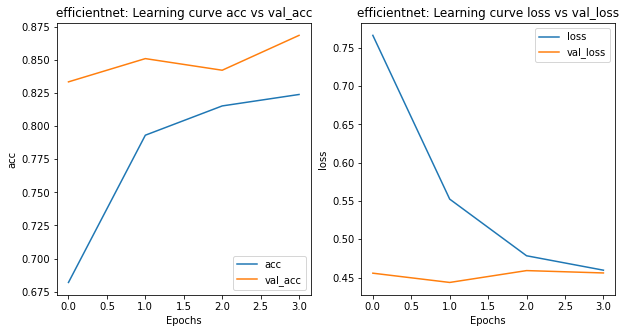


loading best weights model

Run evaluation.........
1/1 [==============================] - 7s 7s/step - loss: 0.4561 - acc: 0.8684

Training accuracy: 0.8497359752655029
Validation accuracy: 0.8684210777282715
Wall time: 8min 5s


In [20]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'cross_event_ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=5 * 1e-3,batch_size=128,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=4,init_lr=1e-3,max_lr=1e-2)

### EfficientNet no augmentation, finetuned 

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =cross_event_ecuador
finetuning =True
lr =0.005

Creating dataset.....
Found 2211 validated image filenames.
Found 114 validated image filenames.
Found 114 validated image filenames.
steps_per_epochs: 17
validations_steps: 1
Model architecture...........
lr in model = 0.005
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)     

C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
17/17 [==============================] - 88s 5s/step - loss: 0.5937 - acc: 0.7758 - val_loss: 0.5479 - val_acc: 0.7982
Epoch 3/5
17/17 [==============================] - 88s 5s/step - loss: 0.5065 - acc: 0.8065 - val_loss: 0.5540 - val_acc: 0.7982
Epoch 4/5
17/17 [==============================] - 95s 6s/step - loss: 0.4787 - acc: 0.8224 - val_loss: 0.5635 - val_acc: 0.7807
Epoch 5/5
17/17 [==============================] - 89s 5s/step - loss: 0.4580 - acc: 0.8157 - val_loss: 0.5422 - val_acc: 0.8070



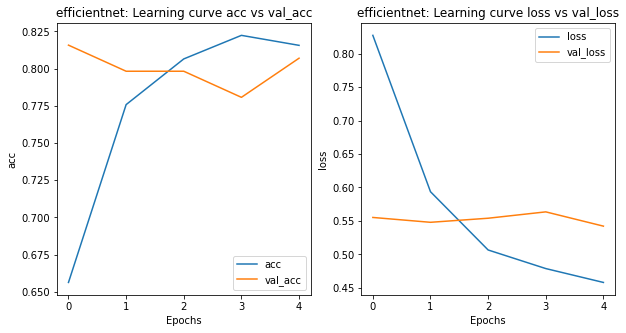


loading best weights model

Run evaluation.........
1/1 [==============================] - 6s 6s/step - loss: 0.5422 - acc: 0.8070

Training accuracy: 0.8386942148208618
Validation accuracy: 0.8070175647735596

******Fine tuning***********************
finetuning lr =5e-05
finetuning epochs =10
init LR epochs =1e-05
max LR epochs =0.0001

Training..................
Epoch 6/10
17/17 [==============================] - 500s 26s/step - loss: 0.4384 - acc: 0.8369 - val_loss: 0.5728 - val_acc: 0.8158
Epoch 7/10
17/17 [==============================] - 344s 21s/step - loss: 0.3531 - acc: 0.8689 - val_loss: 0.5889 - val_acc: 0.8070
Epoch 8/10
17/17 [==============================] - 333s 20s/step - loss: 0.3001 - acc: 0.8920 - val_loss: 0.5984 - val_acc: 0.7895
Epoch 9/10
17/17 [==============================] - 369s 22s/step - loss: 0.2779 - acc: 0.9088 - val_loss: 0.6139 - val_acc: 0.7807
Epoch 10/10
17/17 [==============================] - 362s 21s/step - loss: 0.2114 - acc: 0.9371 - val_lo

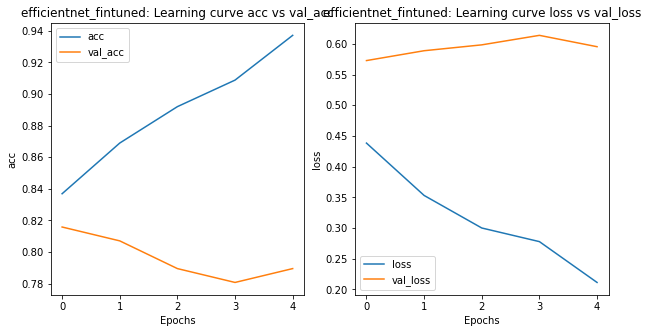

1/1 [==============================] - 5s 5s/step - loss: 0.6841 - acc: 0.7544

Training finetune accuracy: 0.8252520561218262
Validation finetune accuracy: 0.7543859481811523
Wall time: 43min 22s


In [29]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'cross_event_ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=5 * 1e-3,batch_size=128,do_finetune=True,
                use_clr= False,buffer_size=10,n_epochs=5,init_lr=1e-3,max_lr=1e-2)

### EfficientNet no augmentation, finetuned with CLR

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =cross_event_ecuador
finetuning =False
lr =0.001

Creating dataset.....
Found 22111 validated image filenames.
Found 1140 validated image filenames.
Found 1140 validated image filenames.
steps_per_epochs: 173
validations_steps: 9
using cyclical LR for training
Model architecture...........
lr in model = <tensorflow_addons.optimizers.cyclical_learning_rate.CyclicalLearningRate object at 0x7f3944091e50>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                

/usr/local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


173/173 [==============================] - 919s 5s/step - loss: 0.6780 - acc: 0.7614 - val_loss: 0.6164 - val_acc: 0.7886
Epoch 2/5
173/173 [==============================] - 896s 5s/step - loss: 0.9491 - acc: 0.7464 - val_loss: 0.9043 - val_acc: 0.7746
Epoch 3/5
173/173 [==============================] - 899s 5s/step - loss: 0.6490 - acc: 0.7863 - val_loss: 0.9716 - val_acc: 0.7395



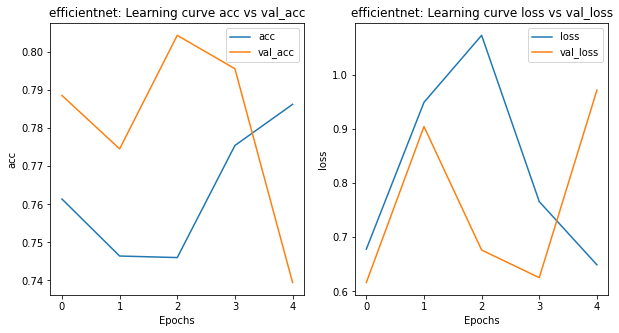


loading best weights model

Run evaluation.........
9/9 [==============================] - 48s 5s/step - loss: 0.9716 - acc: 0.7395

Training accuracy: 0.779159665107727
Validation accuracy: 0.7394737005233765
CPU times: user 3h 57min 10s, sys: 1h 30min 45s, total: 5h 27min 55s
Wall time: 1h 31min 10s


In [ ]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'cross_event_ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=128,do_finetune=False,
                use_clr= True,buffer_size=10,n_epochs=5,init_lr=5 * 1e-3,max_lr=5 * 1e-2)

## Prediction

In [21]:
train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'cross_event_ecuador',
                                    is_augment=False,batch_size=128,buffer_size=100)

Found 2210 validated image filenames.
Found 114 validated image filenames.
Found 114 validated image filenames.
steps_per_epochs: 17
validations_steps: 1


C:\Users\wsn8\AppData\Local\conda\conda\envs\py37ml\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [52]:
for images, labels  in test_ds.take(1):
    print(labels)

tf.Tensor(
[0. 2. 2. 0. 2. 2. 0. 2. 2. 2. 2. 1. 0. 0. 2. 2. 0. 2. 2. 2. 0. 2. 2. 0.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 2. 2. 0. 2. 2. 0. 0. 0. 0. 2. 2. 0. 0.
 2. 2. 2. 2. 0. 0. 2. 0. 0. 0. 0. 2. 2. 2. 2. 0. 2. 2. 0. 2. 2. 2. 2. 2.
 0. 0. 2. 0. 1. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 0. 2. 2. 0. 1.
 0. 2. 2. 2. 2. 2. 1. 0. 2. 2. 2. 2. 2. 2. 0. 1. 2. 0. 0. 2. 2. 2. 2. 2.
 2. 0. 0. 0. 1. 0. 0. 2.], shape=(128,), dtype=float32)


In [22]:
rs1,rs1, model = rs
results_test = model.evaluate(test_ds, steps=validation_steps, return_dict=True)
results_test

1/1 [==============================] - 5s 5s/step - loss: 0.6798 - acc: 0.7807


{'loss': 0.6798001527786255, 'acc': 0.780701756477356}

In [23]:

def get_images(x,y):
    return x

def get_labels(x,y):
    return y

In [24]:
%%time
import numpy as np

test_images = test_ds.map(get_images)
test_labels = test_ds.map(get_labels)



def batch_predict(images_ds,label_ds,model,validation_steps):
    
    y_true = np.concatenate([y for y in label_ds.take(validation_steps)])
    preds = model.predict(images_ds,steps=validation_steps)
    preds_labels = np.argmax(preds,axis=-1)
    
    results = pd.DataFrame({'y_true':y_true,
                      'y_pred':preds_labels})
    
    return results

results = batch_predict(test_images,test_labels,model,validation_steps)
results 

Wall time: 16.8 s


,y_true,y_pred
0,0.0,0
1,2.0,0
2,2.0,2
3,2.0,2
4,0.0,0
...,...,...
109,2.0,2
110,2.0,2
111,2.0,2
112,2.0,2


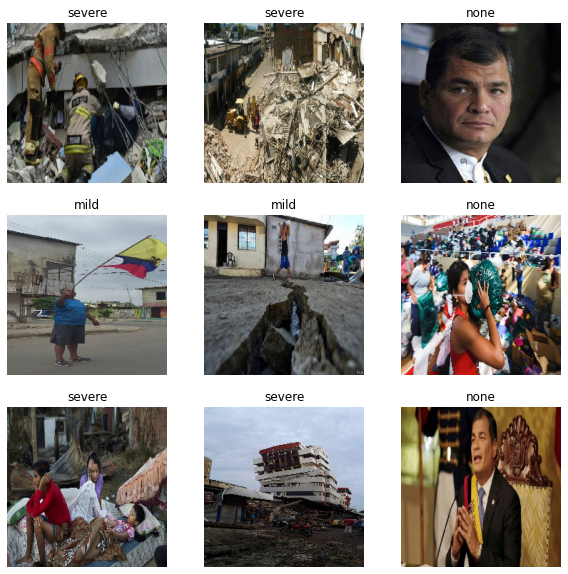

In [50]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

In [25]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score
import pandas as pd

def compute_metrics(pred):
    labels = pred.y_true
    preds = pred.y_pred
    acc = accuracy_score(labels, preds)
    #bal_acc = balanced_accuracy_score(labels, preds)
    precision = precision_score(labels,preds,average='weighted',zero_division=0)
    recall = recall_score(labels,preds,average='weighted',zero_division=0)
    f1 = f1_score(labels,preds,average='weighted',zero_division=0)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

compute_metrics(results)

{'accuracy': 0.7807017543859649,
 'f1': 0.7792029092338689,
 'precision': 0.7852206273258905,
 'recall': 0.7807017543859649}

In [26]:
from sklearn.metrics import classification_report
print(classification_report(results.y_true, results.y_pred, target_names=class_names,zero_division=0,output_dict=False))

              precision    recall  f1-score   support

        none       0.73      0.85      0.78        47
        mild       0.33      0.25      0.29         4
      severe       0.86      0.76      0.81        63

    accuracy                           0.78       114
   macro avg       0.64      0.62      0.63       114
weighted avg       0.79      0.78      0.78       114



In [27]:
from sklearn.metrics import classification_report
classes_report = classification_report(results.y_true, results.y_pred, target_names=class_names,zero_division=0,output_dict=True)

In [28]:
classes_report

{'none': {'precision': 0.7272727272727273,
  'recall': 0.851063829787234,
  'f1-score': 0.7843137254901961,
  'support': 47},
 'mild': {'precision': 0.3333333333333333,
  'recall': 0.25,
  'f1-score': 0.28571428571428575,
  'support': 4},
 'severe': {'precision': 0.8571428571428571,
  'recall': 0.7619047619047619,
  'f1-score': 0.8067226890756302,
  'support': 63},
 'accuracy': 0.7807017543859649,
 'macro avg': {'precision': 0.6392496392496393,
  'recall': 0.6209895305639986,
  'f1-score': 0.6255835667600373,
  'support': 114},
 'weighted avg': {'precision': 0.7852206273258905,
  'recall': 0.7807017543859649,
  'f1-score': 0.7792029092338689,
  'support': 114}}